### Imports

In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from tqdm import tqdm
import pickle
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

from collections import Counter

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import time

### Loading datasets

In [2]:
submission = pd.read_csv('datasets/sample_submission.csv')
test = pd.read_csv('datasets/test.csv')
train = pd.read_csv('datasets/train.csv')

In [3]:
pd.set_option('max_colwidth',200)

In [4]:
train.loc[train['text'].str.contains('http')].target.value_counts()

1    2172
0    1799
Name: target, dtype: int64

In [5]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

In [6]:
# Remove all text that start with html
train['text']=train['text'].apply(lambda x : remove_html(x))

In [7]:
# lets check if this clean works
train.loc[train['text'].str.contains('http')].target.value_counts()

0    1
Name: target, dtype: int64

In [8]:
# Remove all text that start with html in test
test['text']=test['text'].apply(lambda x : remove_html(x))

In [9]:
def clean_text(text):
 
    text = re.sub('[^a-zA-Z]', ' ', text)  

    text = text.lower()  

    # split to array(default delimiter is " ") 
    text = text.split()  
    
    text = [w for w in text if not w in set(stopwords.words('english'))] 

    text = ' '.join(text)    
            
    return text

In [10]:
text = train.text[3]
print(text)
clean_text(text)

13,000 people receive #wildfires evacuation orders in California 


'people receive wildfires evacuation orders california'

In [11]:
# Apply clean text 
train['text'] = train['text'].apply(lambda x : clean_text(x))

In [12]:
# Apply clean text 
test['text']=test['text'].apply(lambda x : clean_text(x))

In [13]:
# How many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [14]:
text_values = train["text"]

counter = counter_word(text_values)

In [15]:
print(f"The len of unique words is: {len(counter)}")
list(counter.items())[:10]

The len of unique words is: 16070


[('deeds', 2),
 ('reason', 20),
 ('earthquake', 50),
 ('may', 89),
 ('allah', 9),
 ('forgive', 2),
 ('us', 128),
 ('forest', 66),
 ('fire', 254),
 ('near', 56)]

Попробуем обучить 

 Train Test Split

In [16]:
# The maximum number of words to be used. (most frequent)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [17]:
# this is base in 80% of the data, an only text and targert at this moment

training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]

In [18]:
print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',testing_sentences.shape)

The Shape of training  (6090,)
The Shape of testing (1523,)


In [19]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [20]:
word_index = tokenizer.word_index

In [21]:
# Lets see the first 10 elements
print("The first word Index are: ")
for x in list(word_index)[0:15]:
    print (" {},  {} ".format(x,  word_index[x]))

# If you want to see completed -> word_index

The first word Index are: 
 <XXX>,  1 
 amp,  2 
 like,  3 
 fire,  4 
 get,  5 
 via,  6 
 new,  7 
 people,  8 
 news,  9 
 emergency,  10 
 one,  11 
 disaster,  12 
 body,  13 
 video,  14 
 burning,  15 


In [23]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

check Inverse for see how it works

In [25]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [26]:
# Lets see the first 10 elements
print("THe first reverse word Index are: ")
for x in list(reverse_word_index)[0:15]:
    print (" {},  {} ".format(x,  reverse_word_index[x]))

# If you want to see completed -> reverse_word_index

THe first reverse word Index are: 
 1,  <XXX> 
 2,  amp 
 3,  like 
 4,  fire 
 5,  get 
 6,  via 
 7,  new 
 8,  people 
 9,  news 
 10,  emergency 
 11,  one 
 12,  disaster 
 13,  body 
 14,  video 
 15,  burning 


In [27]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [28]:
decode(training_sequences[1]) # this can be usefull for check predictions

'forest fire near la ronge sask canada'

In [29]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Creating the Model

In [33]:
# Model Definition with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 32)            514240    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 14)                1806      
                                                                 
 dense_3 (Dense)             (None, 1)                 15        
                                                                 
Total params: 565,725
Trainable params: 565,725
Non-trainable params: 0
_________________________________________________________________


### Neural networks

In [35]:
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')

Epoch 1/10
191/191 [==============================] - 6s 14ms/step - loss: 0.5503 - accuracy: 0.7176 - val_loss: 0.4824 - val_accuracy: 0.7879
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2881 - accuracy: 0.8885 - val_loss: 0.5108 - val_accuracy: 0.7577
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.1665 - accuracy: 0.9445 - val_loss: 0.5976 - val_accuracy: 0.7426
Epoch 4/10
191/191 [==============================] - 2s 11ms/step - loss: 0.1169 - accuracy: 0.9639 - val_loss: 0.7117 - val_accuracy: 0.7078
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.0909 - accuracy: 0.9718 - val_loss: 0.7331 - val_accuracy: 0.7374
Epoch 6/10
191/191 [==============================] - 2s 10ms/step - loss: 0.0768 - accuracy: 0.9750 - val_loss: 0.7701 - val_accuracy: 0.7275
Epoch 7/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0699 - accuracy: 0.9736 - val_loss: 0.8953 - val_accuracy: 0.7282


In [36]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.550342,0.717570,0.482395,0.787919
1,0.288088,0.888506,0.510760,0.757715
2,0.166461,0.944499,0.597561,0.742613
3,0.116880,0.963875,0.711710,0.707814
4,0.090852,0.971757,0.733085,0.737360


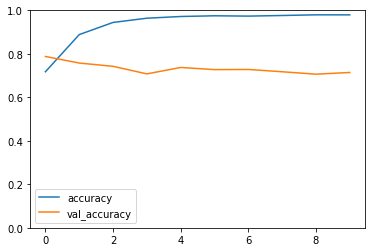

In [37]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);

Model Evaluation¶

In [38]:
testing_padded[0]

array([ 654, 1253,  647,  113,  526,  666,    1,  851,  561,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [39]:
model.predict(testing_padded)

48/48 [==============================] - 1s 3ms/step


array([[3.3211632e-04],
       [7.6923091e-03],
       [5.7749557e-01],
       ...,
       [9.9313396e-01],
       [9.9793649e-01],
       [9.9997687e-01]], dtype=float32)

In [40]:
predictions =model.predict(testing_padded)  # predict_ clases because is classification problem with the split test

48/48 [==============================] - 0s 2ms/step


In [41]:
testing_sequences2 = tokenizer.texts_to_sequences(test.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [42]:
predictions = model.predict(testing_padded2)

102/102 [==============================] - 0s 3ms/step


In [43]:
# sample of submission
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [44]:
submission['target'] = (predictions > 0.5).astype(int)

In [45]:
submission.to_csv("submission_TFlow_26-10.csv", index=False, header=True)

**Kaggle Score: 0.74471**

https://www.kaggle.com/code/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud